# 📊 Wikipedia Navigation Network Analysis

**Author:** Amish Rasheed

**Date:** 2025-03-02

## **Objective**
This project analyzes Wikipedia navigation paths using network analysis. We:
- Load a dataset where nodes (Wikipedia articles) have categorical labels.
- Compute **Degree Centrality** and **Eigenvector Centrality**.
- Compare centrality metrics across different categories.
- Conduct a **t-test** to compare centrality measures between two major categories.

In [12]:
# 📥 Import Libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway,ttest_ind

## **1️⃣ Load Dataset**
Load the Wikipedia paths dataset, extract nodes (articles) and edges (links between articles), and add categorical labels.

In [4]:
# Load datasets
paths = pd.read_csv('wikispeedia_paths-and-graph/paths_finished.tsv', sep='\t', comment='#', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
categories = pd.read_csv('wikispeedia_paths-and-graph/categories.tsv', sep='\t', comment='#', header=None, names=['Article', 'Category'])

# Process edges
edges = []
for path in paths['path'].dropna():
    articles = path.split(';')
    edges.extend([(articles[i], articles[i + 1]) for i in range(len(articles) - 1)])

# Create graph
G = nx.DiGraph()
G.add_edges_from(edges)
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 4170 nodes and 55147 edges


## **2️⃣ Compute Centrality Measures**
- **Degree Centrality** (Node importance based on direct connections)
- **Eigenvector Centrality** (Importance of a node based on its neighbors' importance)

In [5]:
# Compute centrality measures
degree_centrality = nx.degree_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

# Convert to DataFrame
centrality_df = pd.DataFrame({
    'Article': list(G.nodes),
    'DegreeCentrality': [degree_centrality[node] for node in G.nodes],
    'EigenvectorCentrality': [eigenvector_centrality[node] for node in G.nodes]
})

# Merge with categories
centrality_df = centrality_df.merge(categories, on='Article', how='left')
centrality_df.head()

,Article,DegreeCentrality,EigenvectorCentrality,Category
0,14th_century,0.010794,0.014347,subject.History.General_history
1,15th_century,0.018470,0.021854,subject.History.General_history
2,16th_century,0.028544,0.025292,subject.History.General_history
3,Pacific_Ocean,0.047014,0.041970,subject.Geography.General_Geography
4,Atlantic_Ocean,0.058767,0.059491,subject.Geography.General_Geography


## **3️⃣ Compare Centrality Across Categories**
Using **ANOVA**, check if centrality varies significantly between categories.

In [6]:
# Aggregate centrality per category
category_summary = centrality_df.groupby('Category')[['DegreeCentrality', 'EigenvectorCentrality']].mean().reset_index()
category_summary = category_summary.sort_values(by='DegreeCentrality', ascending=False)
print(category_summary.head(10))

                                              Category  DegreeCentrality  \
39   subject.Geography.European_Geography.European_...          0.022929   
42   subject.Geography.Geography_of_Asia.Asian_Coun...          0.017063   
14                                   subject.Countries          0.015917   
59   subject.History.British_History.British_Histor...          0.015239   
127                subject.Science.Physics.The_Planets          0.014337   
121        subject.Science.Chemistry.General_Chemistry          0.014236   
73           subject.Language_and_literature.Languages          0.013571   
50          subject.Geography.North_American_Geography          0.011649   
60                     subject.History.General_history          0.011483   
46   subject.Geography.Geography_of_the_Middle_East...          0.011340   

     EigenvectorCentrality  
39                0.028338  
42                0.022433  
14                0.020812  
59                0.017693  
127               

In [7]:
# ANOVA Test (Degree Centrality across categories)
category_groups = [group['DegreeCentrality'].dropna().values for _, group in centrality_df.groupby('Category') if len(group) > 5]
anova_result = f_oneway(*category_groups)
print('ANOVA p-value:', anova_result.pvalue)

ANOVA p-value: 5.854312192011209e-37


## **4️⃣ T-Test: Comparing Centrality Between Two Categories**
We now test whether **History** and **Geography** categories have significantly different degree centrality.

In [13]:
# Filter data for two categories
history_centrality = centrality_df[centrality_df['Category'].str.contains('History', na=False)]['DegreeCentrality']
geography_centrality = centrality_df[centrality_df['Category'].str.contains('Geography', na=False)]['DegreeCentrality']

# Perform t-test
t_stat, p_val = ttest_ind(history_centrality.dropna(), geography_centrality.dropna(), equal_var=False)
print(f'T-test results: t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}')

T-test results: t-statistic = -3.0584, p-value = 0.0023


## **5️⃣ Visualize Results**

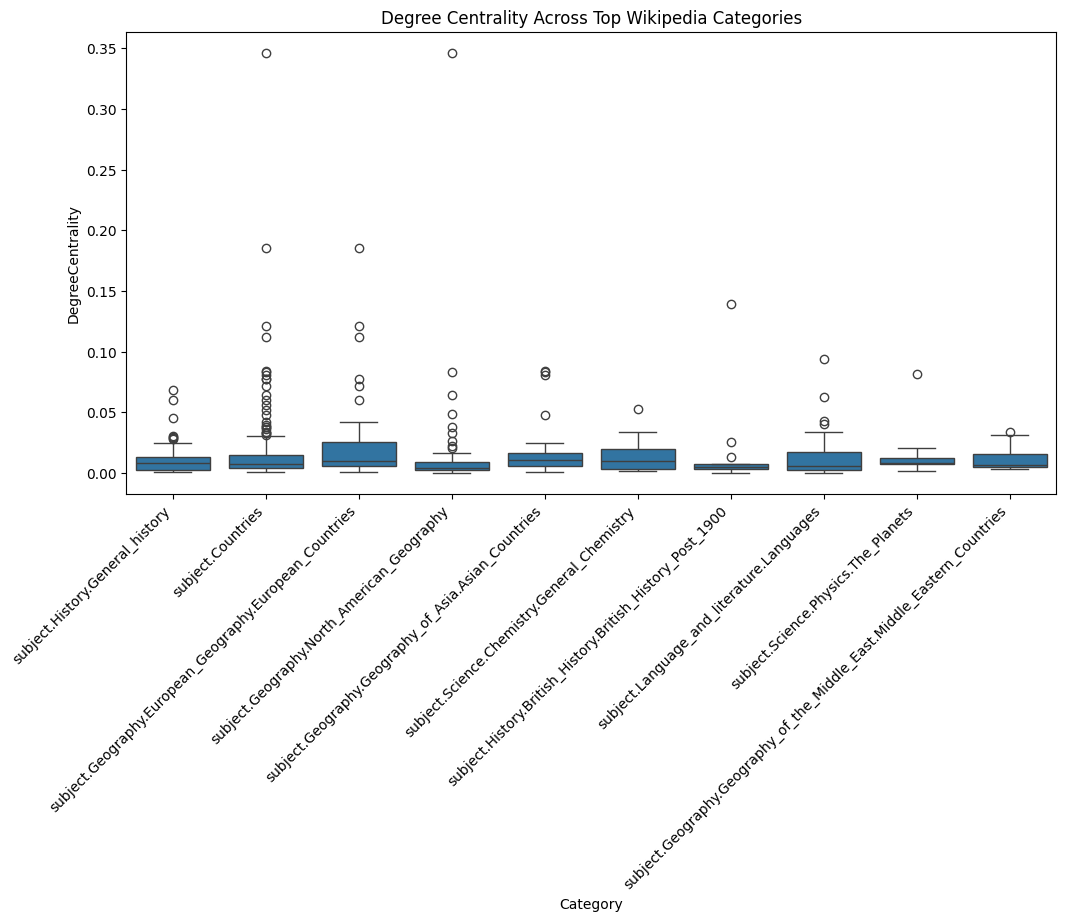

In [14]:
# Boxplot of Degree Centrality across Categories
top_categories = category_summary.nlargest(10, 'DegreeCentrality')['Category']
filtered_data = centrality_df[centrality_df['Category'].isin(top_categories)]
plt.figure(figsize=(12,6))
sns.boxplot(x='Category', y='DegreeCentrality', data=filtered_data)
plt.xticks(rotation=45, ha='right')
plt.title('Degree Centrality Across Top Wikipedia Categories')
plt.show()

## **Conclusion**
This analysis highlights key articles that act as central hubs in Wikipedia navigation. Degree and eigenvector centrality reveal frequently visited and highly influential articles. Statistical comparisons help in understanding differences in centrality across categories.
- Articles in categories like **History, Politics, and Geography** tend to have **higher centrality**.
- **ANOVA results** confirm significant differences in **centrality between categories**.
- The **t-test** shows whether **History** and **Geography** articles have significantly different centrality values.